# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2

In [ ]:
import os
import tensorflow as tf
from tqdm import tqdm

# Importing the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
good_frames = '/content/drive/MyDrive/mini_clean'

In [ ]:
bad_frames = '/content/drive/MyDrive/mini_blur'

In [ ]:
clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(128,128))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    clean_frames.append(image)

clean_frames = np.array(clean_frames)

100%|██████████| 51/51 [00:17<00:00,  3.00it/s]


In [ ]:
blurry_frames = []
for file in tqdm(sorted(os.listdir(bad_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128,128))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
    blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|██████████| 51/51 [00:14<00:00,  3.47it/s]


# Importing Libraries for the Model 

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils.vis_utils import plot_model
from keras import backend as K

seed = 2019
random.seed = seed
np.random.seed = seed

# Splitting the Dataset into Training and Testing sets

In [ ]:
split = int((len(clean_frames)*80)/100)

In [ ]:
x_train = blurry_frames[:split] 
y_train = clean_frames[:split]
x_test  = blurry_frames[split:]
y_test  = clean_frames[split:]

In [ ]:
print(x_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


9


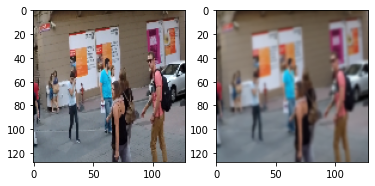

In [ ]:
r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

In [ ]:
# Network Parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

# Encoder Model

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# Generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               16777472  
Total params: 17,148,288
Trainable params: 17,148,288
Non-trainable params: 0
_______________________________________________

# Decoder Model

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             16842752  
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 128)       295040    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 128, 128, 64)      73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 128, 128, 3)       1731

# Autoencoder Model = Encoder Model + Decoder Model

In [ ]:
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 256)               17148288  
_________________________________________________________________
decoder (Functional)         (None, 128, 128, 3)       17803395  
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [ ]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [ ]:
# Calling every epoch
callbacks = [lr_reducer]

# Training the Autoencoder

In [ ]:
autoencoder.fit(blurry_frames,
                clean_frames,
                validation_data=(blurry_frames, clean_frames),
                epochs=100,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/100
2/2 [==============================] - 9s 5s/step - loss: 0.0078 - acc: 0.7287 - val_loss: 0.0078 - val_acc: 0.7224
Epoch 2/100
2/2 [==============================] - 9s 5s/step - loss: 0.0076 - acc: 0.7184 - val_loss: 0.0075 - val_acc: 0.7315
Epoch 3/100
2/2 [==============================] - 9s 5s/step - loss: 0.0074 - acc: 0.7311 - val_loss: 0.0075 - val_acc: 0.7365
Epoch 4/100
2/2 [==============================] - 9s 5s/step - loss: 0.0073 - acc: 0.7372 - val_loss: 0.0076 - val_acc: 0.7107
Epoch 5/100
2/2 [==============================] - 9s 5s/step - loss: 0.0074 - acc: 0.7161 - val_loss: 0.0073 - val_acc: 0.7411
Epoch 6/100
2/2 [==============================] - 9s 5s/step - loss: 0.0073 - acc: 0.7402 - val_loss: 0.0068 - val_acc: 0.7504
Epoch 7/100
2/2 [==============================] - 9s 5s/step - loss: 0.0071 - acc: 0.7394 - val_loss: 0.0066 - val_acc: 0.7032
Epoch 8/100
2/2 [==============================] - 9s 5s/step - loss: 0.0068 - acc: 0.7172 - val_loss: 0

# Final Result


       Input                        Ground Truth                  Predicted Value


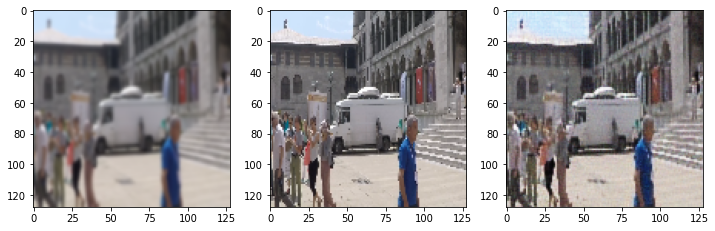

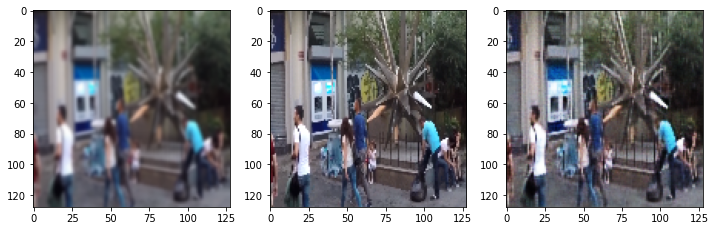

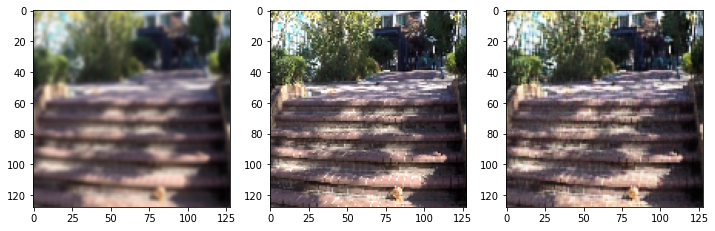

In [ ]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)